<a href="https://colab.research.google.com/github/Ayesha-Imr/Gen-AI-Projects/blob/main/Multimodal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setting up

In [ ]:
!pip install --quiet replicate langchain langchain-community weaviate-client llama_index ftfy regex tqdm git+https://github.com/openai/CLIP.git torch torchvision matplotlib scikit-image PyMuPDF

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/RSA RAG Docs
%ls

/content/gdrive/My Drive/RSA RAG Docs
data_pdf/  rsa-doc.gdoc  rsa-doc.pdf


In [ ]:
import fitz  # PyMuPDF
from pathlib import Path
from datetime import datetime
import clip
import torch
from PIL import Image
import os
import weaviate
from weaviate.auth import AuthApiKey
from weaviate.classes.config import Property, DataType, Configure
from weaviate.util import generate_uuid5


##Extracting text and images from slides pdf separately

In [ ]:
pdf_path = 'rsa-doc.pdf'
data_path = Path("data_pdf")

if not data_path.exists():
    Path.mkdir(data_path)

# Extract text and images
doc = fitz.open(pdf_path)

# Extract text
text_file = data_path / "document_text.txt"
with open(text_file, 'w') as tf:
    for page in doc:
        text = page.get_text()
        tf.write(text)

# Extract images
image_metadata_dict = {}
image_uuid = 0
for page_num in range(len(doc)):
    for img in doc.get_page_images(page_num):
        xref = img[0]
        base_image = doc.extract_image(xref)
        image_bytes = base_image["image"]
        image_ext = base_image["ext"]
        image_filename = data_path / f"image_{image_uuid}.{image_ext}"
        with open(image_filename, "wb") as img_file:
            img_file.write(image_bytes)
        image_metadata_dict[image_uuid] = {
            "filename": f"image_{image_uuid}.{image_ext}",
            "img_path": str(image_filename),
        }
        image_uuid += 1


##Embedding extracted text and images

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocess text
with open(text_file, 'r') as tf:
    text_data = tf.read().splitlines()

# Preprocess images
image_files = [image_metadata_dict[uuid]['img_path'] for uuid in image_metadata_dict]
processed_images = [preprocess(Image.open(img_path)).unsqueeze(0).to(device) for img_path in image_files]

# Tokenize and encode text
text_tokens = clip.tokenize(text_data).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

# Encode images
with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(img) for img in processed_images])

# Convert embeddings to numpy for ingestion
text_embeddings_np = text_embeddings.cpu().numpy()
image_embeddings_np = image_embeddings.cpu().numpy()


##Connecting to Weaviate Cloud

In [ ]:
import os

from google.colab import userdata
WCS_URL =  userdata.get('WCS_URL')
WCS_API_KEY =  userdata.get('WCS_API_KEY')

os.environ["WCS_URL"] = WCS_URL
os.environ["WCS_API_KEY"] = WCS_API_KEY

In [ ]:
import weaviate
from weaviate.auth import AuthApiKey

# Connect to Weaviate Cloud
client = weaviate.connect_to_weaviate_cloud(
    cluster_url=os.getenv("WCS_URL"),
    auth_credentials=AuthApiKey(os.getenv("WCS_API_KEY")),
)

print(client.is_ready())

True


Creating collections for text and image storage

In [ ]:
from weaviate.classes.config import Property, DataType, Configure

# Define text collection schema
client.collections.create(
    "RSATextCollection",
    properties=[
        Property(name="text", data_type=DataType.TEXT),
        Property(name="source", data_type=DataType.TEXT),  # Add source metadata
        Property(name="timestamp", data_type=DataType.DATE)  # Add timestamp metadata
    ],
    vectorizer_config=Configure.Vectorizer.none()
)

# Define image collection schema
client.collections.create(
    "RSAImageCollection",
    properties=[
        Property(name="image_path", data_type=DataType.TEXT),
        Property(name="source", data_type=DataType.TEXT),  # Add source metadata
        Property(name="timestamp", data_type=DataType.DATE)  # Add timestamp metadata
    ],
    vectorizer_config=Configure.Vectorizer.none()
)



Inserting text into collection

In [ ]:
from datetime import datetime
from weaviate.util import generate_uuid5

# Function to get current time in RFC3339 format
def get_rfc3339_timestamp():
    return datetime.now().isoformat(timespec='seconds') + 'Z'

# Upload text embeddings with metadata in batch
text_collection = client.collections.get("RSATextCollection")
with text_collection.batch.dynamic() as batch:
    for idx, (text, embedding) in enumerate(zip(text_data, text_embeddings_np)):
        if idx % 10 == 0:
            print(idx, text, embedding.shape)
        obj_uuid = generate_uuid5(f"{text}_{idx}")  # Ensure unique UUID by including the index
        batch.add_object(
            properties={
                "text": text,
                "source": pdf_path,
                "timestamp": get_rfc3339_timestamp()
            },
            uuid=obj_uuid,
            vector=embedding.tolist()
        )

0 SESSION ID: (512,)
10 Security Researcher (512,)
20 Attendees should note that sessions may be audio- or video-recorded and may be published in various  (512,)
30 Most common attack techniques in K8S (512,)
40 Architecture (512,)
50 Namespaces (512,)
60 #RSAC (512,)
70 Node Components (512,)
80 everything (512,)
90 K03: Overly Permissive RBAC Configurations (512,)
100 Kubernetes (512,)
110 Compromised images / registry (512,)
120 Supply Chain Attacks (512,)
130 RCE (512,)
140 A04:2021 (512,)
150 A09:2021 (512,)
160 Exec into container (512,)
170 #RSAC (512,)
180 27 (512,)
190 Access cloud resources (512,)
200 #RSAC (512,)
210 34 (512,)
220 credential (512,)
230 36 (512,)
240 CoreDNS poisoning (512,)
250 Resource Hijacking (512,)
260 Resource Quotas and Limits (512,)
270 runAsNonRoot, runAsUser, runAsGroup (512,)
280 43 (512,)
290 Istio, Linkerd, Consul, etc (512,)
300 #RSAC (512,)
310 ClusterRole (512,)
320 Protect Cluster Against Privilege Pods (512,)
330 psp-default (512,)
340 jsPo

Inserting images into collection

In [ ]:
# Upload image embeddings with metadata in batch
image_collection = client.collections.get("RSAImageCollection")
with image_collection.batch.dynamic() as batch:
    for idx, (image_path, embedding) in enumerate(zip(image_files, image_embeddings_np)):
        if idx % 10 == 0:
            print(idx, image_path, embedding.shape)
        obj_uuid = generate_uuid5(f"{image_path}_{idx}")  # Ensure unique UUID by including the index
        batch.add_object(
            properties={
                "image_path": image_path,
                "source": pdf_path,
                "timestamp": get_rfc3339_timestamp()
            },
            uuid=obj_uuid,
            vector=embedding.tolist()
        )

0 data_pdf/image_0.jpeg (512,)
10 data_pdf/image_10.jpeg (512,)
20 data_pdf/image_20.png (512,)
30 data_pdf/image_30.png (512,)
40 data_pdf/image_40.png (512,)
50 data_pdf/image_50.png (512,)
60 data_pdf/image_60.png (512,)
70 data_pdf/image_70.png (512,)
80 data_pdf/image_80.png (512,)
90 data_pdf/image_90.jpeg (512,)
100 data_pdf/image_100.jpeg (512,)
110 data_pdf/image_110.png (512,)
120 data_pdf/image_120.png (512,)
130 data_pdf/image_130.png (512,)
140 data_pdf/image_140.png (512,)
150 data_pdf/image_150.png (512,)
160 data_pdf/image_160.png (512,)
170 data_pdf/image_170.jpeg (512,)
180 data_pdf/image_180.png (512,)
190 data_pdf/image_190.jpeg (512,)
200 data_pdf/image_200.png (512,)
210 data_pdf/image_210.jpeg (512,)
220 data_pdf/image_220.png (512,)
230 data_pdf/image_230.jpeg (512,)
240 data_pdf/image_240.jpeg (512,)
250 data_pdf/image_250.jpeg (512,)
260 data_pdf/image_260.png (512,)


Printing objects in text collection

In [ ]:
collection = client.collections.get("RSATextCollection")

for item in collection.iterator():
    print(item.uuid, item.properties)

00124f1a-6871-5329-83a8-056c0fc3688d {'text': 'Presentations are intended for educational purposes only and do not replace independent professional ', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 46, tzinfo=datetime.timezone.utc), 'source': 'rsa-doc.pdf'}
0090edf5-1b51-51b9-814c-ff7adcb4dd7f {'text': 'ClusterRole', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 48, tzinfo=datetime.timezone.utc)}
0136232f-8c4a-5243-b9df-e22bf70c288f {'text': 'Network Policies', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 48, tzinfo=datetime.timezone.utc)}
020975eb-ea2a-54b8-92a2-b1f8653c693f {'text': 'Limits', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 48, tzinfo=datetime.timezone.utc)}
033ee9af-09f2-5af6-9468-81ab39b04e74 {'text': 'Security Profiles', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 48, tzinfo=datetime.timezone.utc)}
0373af46-d2a9-5048-af67-70a64d4ac7f4 {'text': '#RSAC',

Printing objects in image collection

In [ ]:
collection = client.collections.get("RSAImageCollection")

for item in collection.iterator():
    print(item.uuid, item.properties)

00a6edf1-d63b-5d7a-a199-65fc1ffa19ff {'image_path': 'data_pdf/image_197.png', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 52, tzinfo=datetime.timezone.utc)}
021c5cd8-e03a-5584-9941-9316686feea5 {'image_path': 'data_pdf/image_106.jpeg', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 50, tzinfo=datetime.timezone.utc), 'source': 'rsa-doc.pdf'}
04d33496-e7c4-592d-a54b-4ef3012d7ce4 {'image_path': 'data_pdf/image_152.png', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 52, tzinfo=datetime.timezone.utc)}
07323409-ab2c-5313-be31-01275c109726 {'image_path': 'data_pdf/image_36.png', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 50, tzinfo=datetime.timezone.utc)}
075c2371-97e8-5402-862a-dead9c5cf6f7 {'image_path': 'data_pdf/image_254.png', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 53, tzinfo=datetime.timezone.utc)}
076b181e-6153-54b9-b2f9-ae13fdb78d3d {'image_path': 'data_pdf/ima

##Vector Search

Defining functions to embed query data in similar manner as the original data

In [ ]:
# Function to embed text query
def embed_text_query(query, model, device):
    query_token = clip.tokenize([query]).to(device)
    with torch.no_grad():
        query_embedding = model.encode_text(query_token)
    return query_embedding.cpu().numpy()

# Function to embed image query
def embed_image_query(image_path, model, preprocess, device):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        query_embedding = model.encode_image(image)
    return query_embedding.cpu().numpy()


Function to perform vector search

In [ ]:
import weaviate.classes as wvc

def search_weaviate(query, query_type, model, preprocess, client, device, collection_name):
    if query_type == "text":
        query_embedding = embed_text_query(query, model, device)
    elif query_type == "image":
        query_embedding = embed_image_query(query, model, preprocess, device)
    else:
        raise ValueError("Query type must be 'text' or 'image'")

    near_vector =  query_embedding.flatten().tolist()

    query_collection = client.collections.get(collection_name)
    response = query_collection.query.near_vector(
        near_vector=near_vector,
        limit=10,
        return_metadata=wvc.query.MetadataQuery(certainty=True)
    )
    return response


Text search

In [ ]:
import json

# Example usage
collection_name = "RSATextCollection"  # Change to "RSAImageCollection" if searching images
query = "components of kubernetes"  # Change to the path of an image file if searching images
query_type = "text"  # Change to "image" if searching images

response = search_weaviate(query, query_type, model, preprocess, client, device, collection_name)
print(response)


QueryReturn(objects=[Object(uuid=_WeaviateUUIDInt('e6b837d2-6153-5942-ba09-c6049b88c7f6'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=0.9930667877197266, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'text': 'Kubernetes Components', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 46, tzinfo=datetime.timezone.utc)}, references=None, vector={}, collection='RSATextCollection'), Object(uuid=_WeaviateUUIDInt('04902669-f432-52f4-9968-4d7226f284a2'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=0.9784079790115356, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'text': 'What Is Kubernetes Anyways?', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 46, tzinfo=datetime.timezone.utc)}, references=None, vector={}, collection='RSATextCollection'), Object(uuid=_WeaviateUUIDInt('59f

In [ ]:
def print_formatted_response(response):
    # Check if response is valid and has objects
    if not response or not hasattr(response, 'objects') or not response.objects:
        print("No valid response data.")
        return

    for obj in response.objects:
        properties = obj.properties
        print("Text:", properties.get('text', 'N/A'))
        print("Source:", properties.get('source', 'N/A'))
        print("Timestamp:", properties.get('timestamp', 'N/A'))
        print("Certainty:", getattr(obj.metadata, 'certainty', 'N/A'))
        print("-" * 50)


print_formatted_response(response)


Text: Kubernetes Components
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9930667877197266
--------------------------------------------------
Text: What Is Kubernetes Anyways?
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9784079790115356
--------------------------------------------------
Text: Introduction to Kubernetes
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9722028970718384
--------------------------------------------------
Text: Kubernetes
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9703652858734131
--------------------------------------------------
Text: Kubernetes Evolution
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9686810970306396
--------------------------------------------------
Text: Kubernetes Application
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:46+00:00
Certainty: 0.9675055742263794
--------------------------------------------------
Text

Image Search

Query Image:


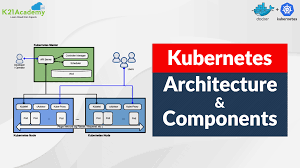

In [ ]:
from PIL import Image
from IPython.display import display

# Load and display the query image
img = Image.open("download.png")
print("Query Image:")
display(img)

In [ ]:
import json

# Example usage
collection_name = "RSAImageCollection"  # Change to "RSAImageCollection" if searching images
query = "download.png"  # Change to the path of an image file if searching images
query_type = "image"  # Change to "image" if searching images

response = search_weaviate(query, query_type, model, preprocess, client, device, collection_name)
print(response)

QueryReturn(objects=[Object(uuid=_WeaviateUUIDInt('20d292fd-7592-524b-ad96-a9d34f5bd57d'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=0.8380905389785767, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data_pdf/image_105.jpeg', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 50, tzinfo=datetime.timezone.utc)}, references=None, vector={}, collection='RSAImageCollection'), Object(uuid=_WeaviateUUIDInt('fffb1480-b2e4-57a0-8551-a64b3af7536d'), metadata=MetadataReturn(creation_time=None, last_update_time=None, distance=None, certainty=0.8336713314056396, score=None, explain_score=None, is_consistent=None, rerank_score=None), properties={'image_path': 'data_pdf/image_103.jpeg', 'source': 'rsa-doc.pdf', 'timestamp': datetime.datetime(2024, 7, 1, 9, 1, 50, tzinfo=datetime.timezone.utc)}, references=None, vector={}, collection='RSAImageCollection'), Object(uuid=_Weaviate

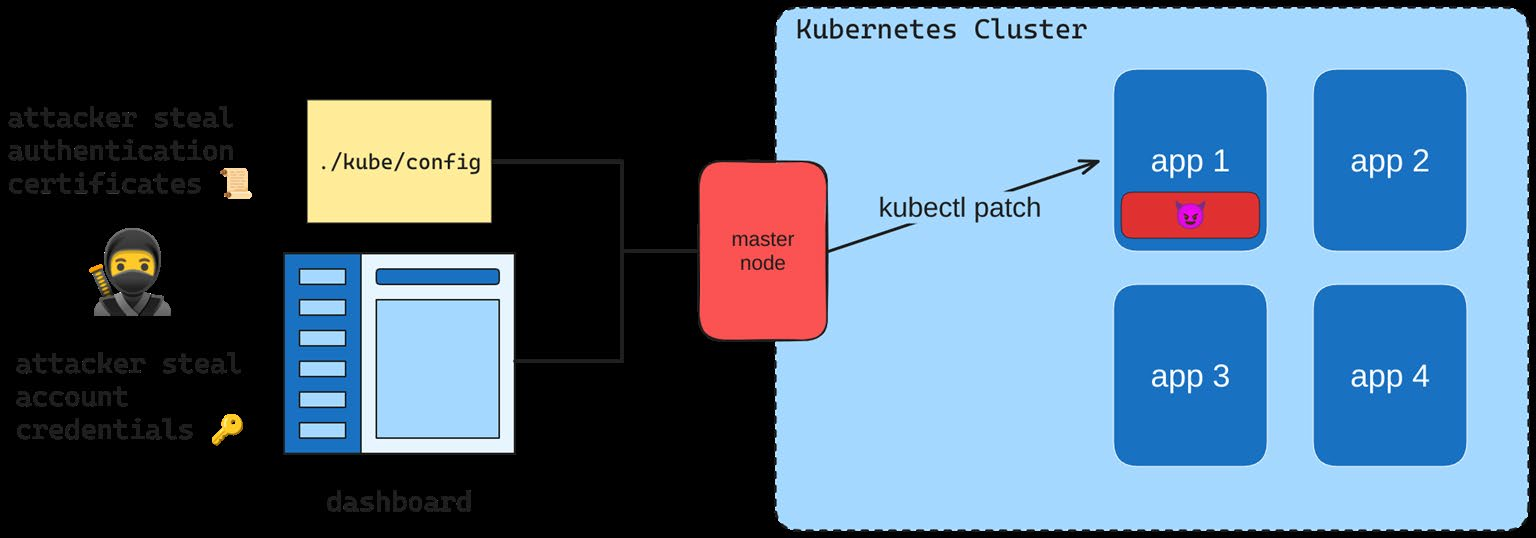

Image Path: data_pdf/image_105.jpeg
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8380905389785767
--------------------------------------------------


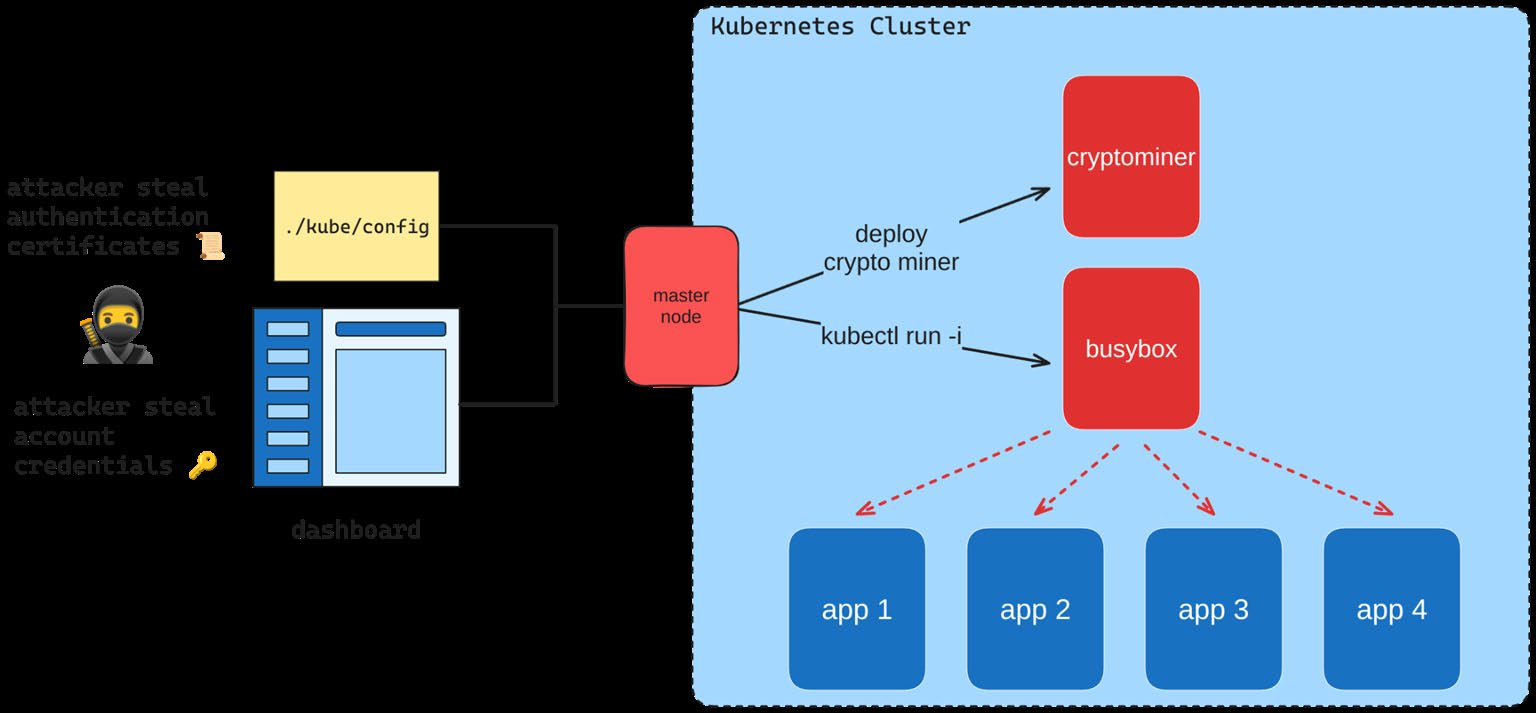

Image Path: data_pdf/image_103.jpeg
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8336713314056396
--------------------------------------------------


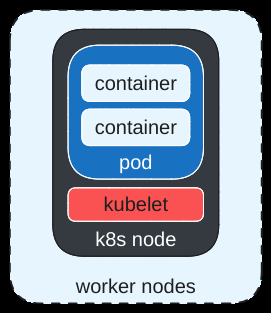

Image Path: data_pdf/image_40.png
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8265403509140015
--------------------------------------------------


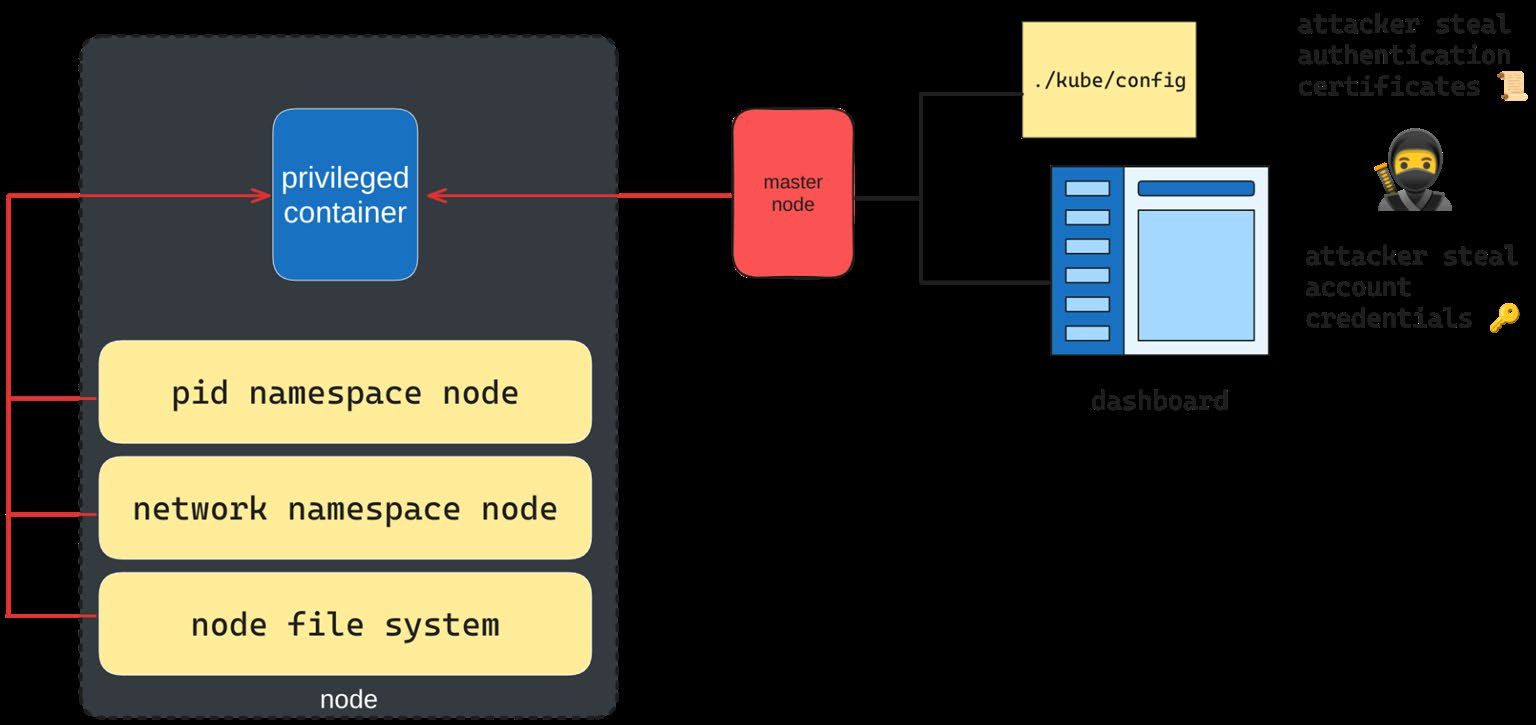

Image Path: data_pdf/image_125.jpeg
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8193550109863281
--------------------------------------------------


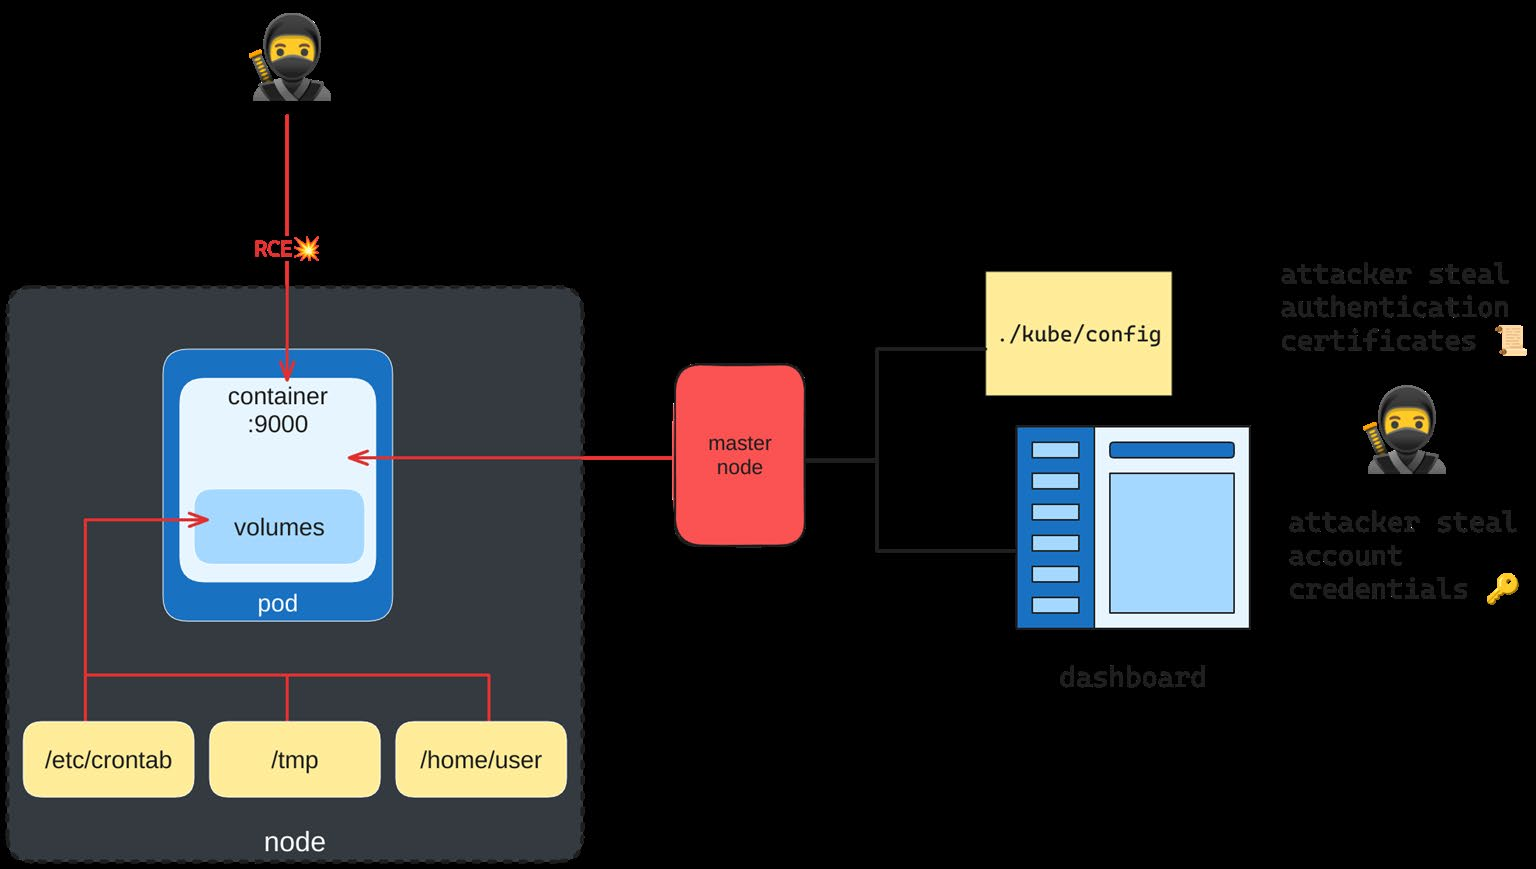

Image Path: data_pdf/image_113.jpeg
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.813544511795044
--------------------------------------------------


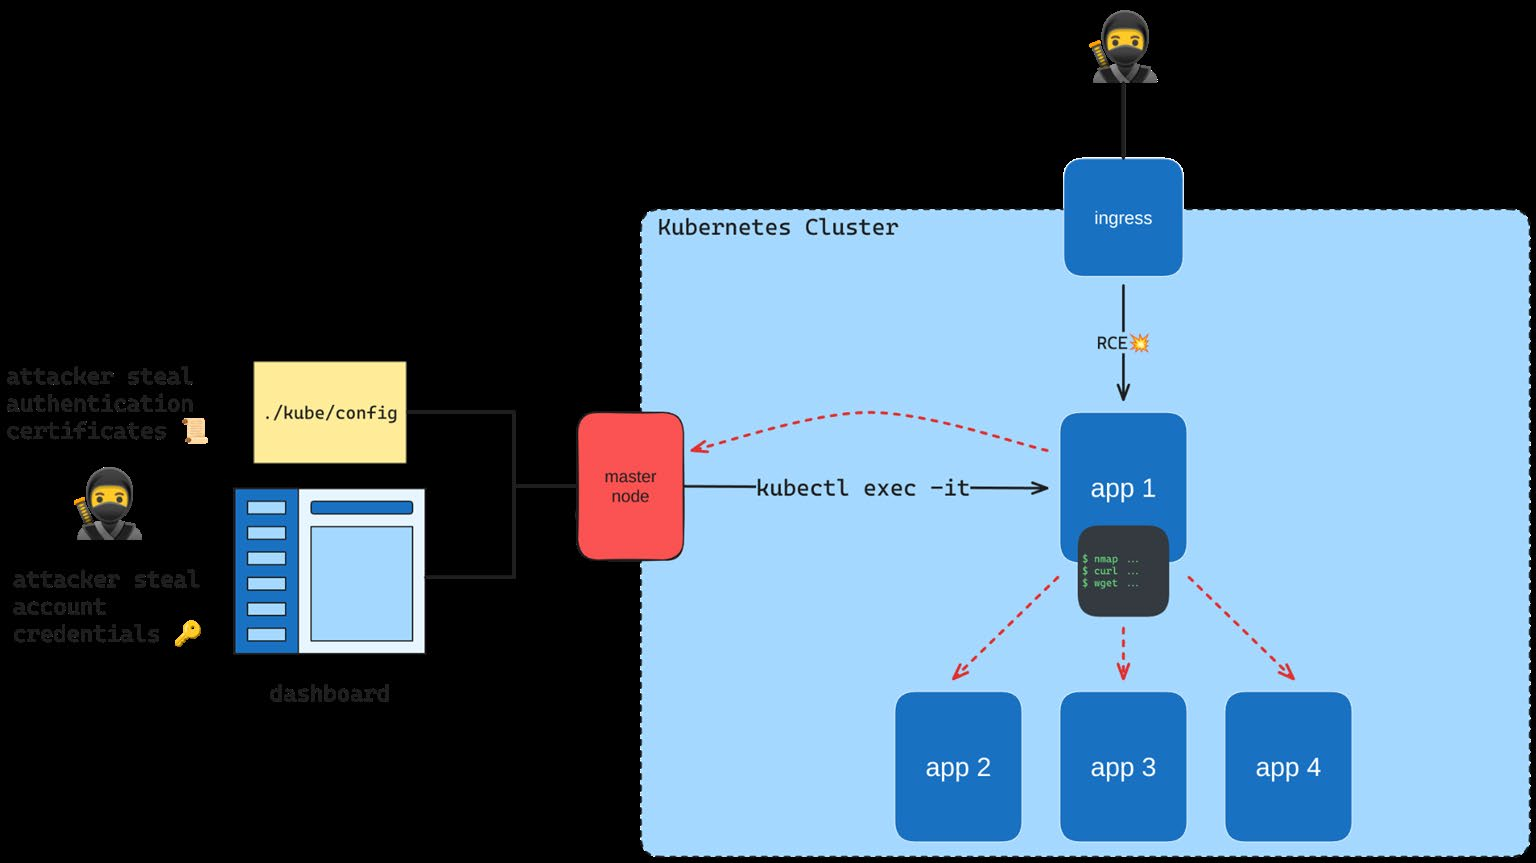

Image Path: data_pdf/image_101.jpeg
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8124507069587708
--------------------------------------------------


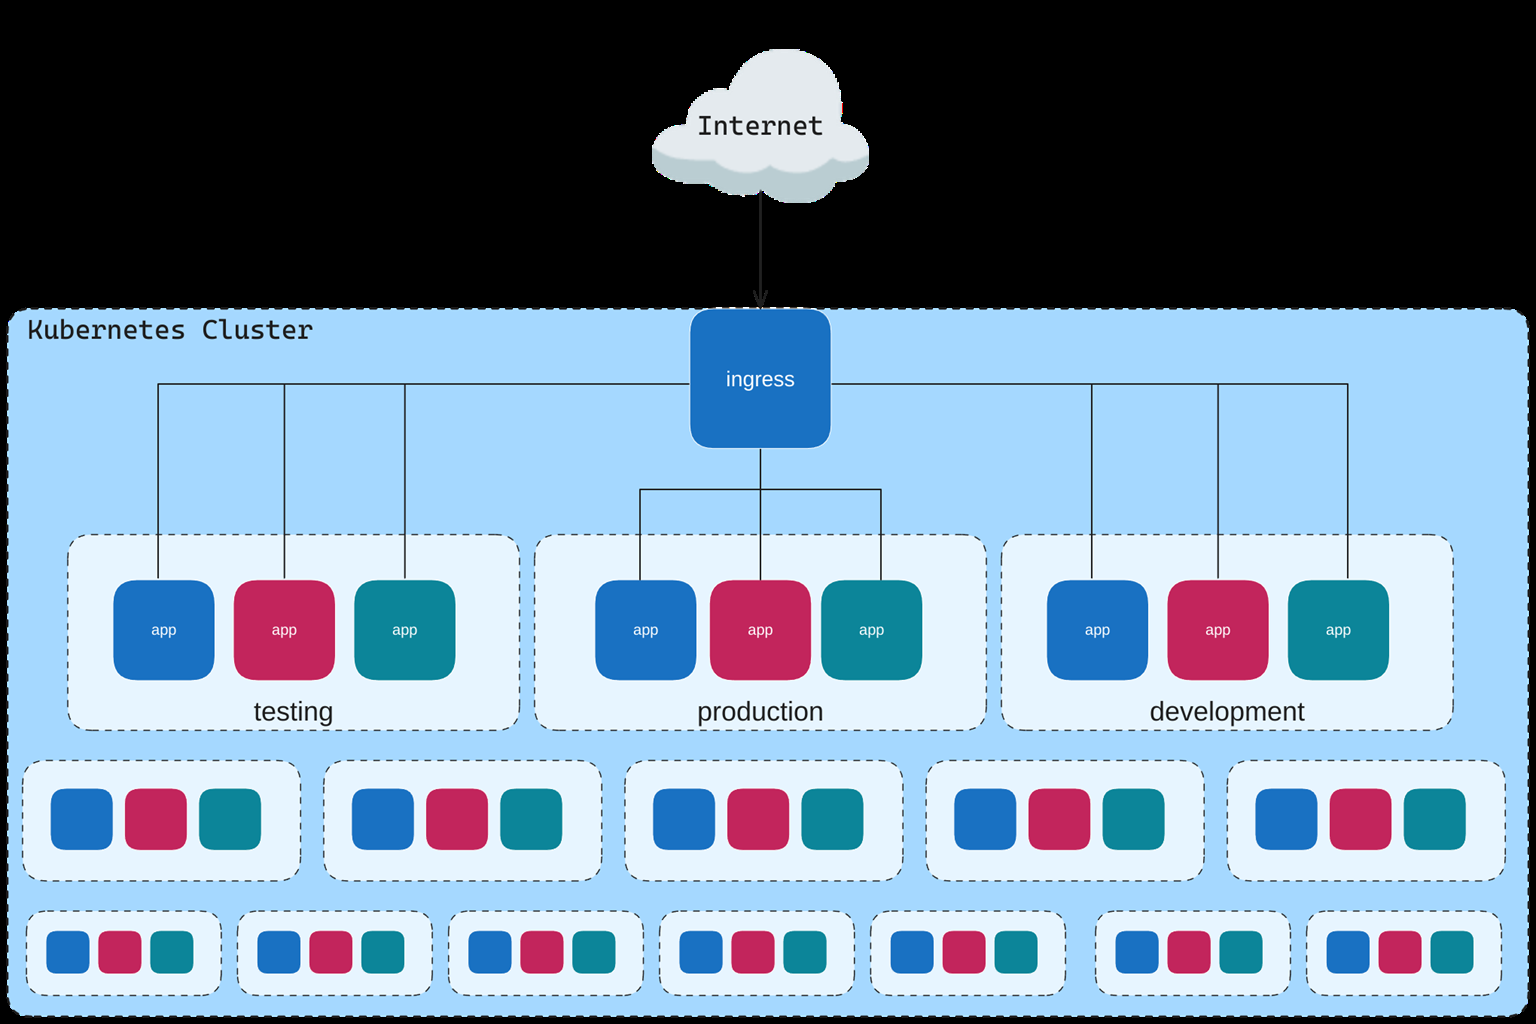

Image Path: data_pdf/image_23.png
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8056537508964539
--------------------------------------------------


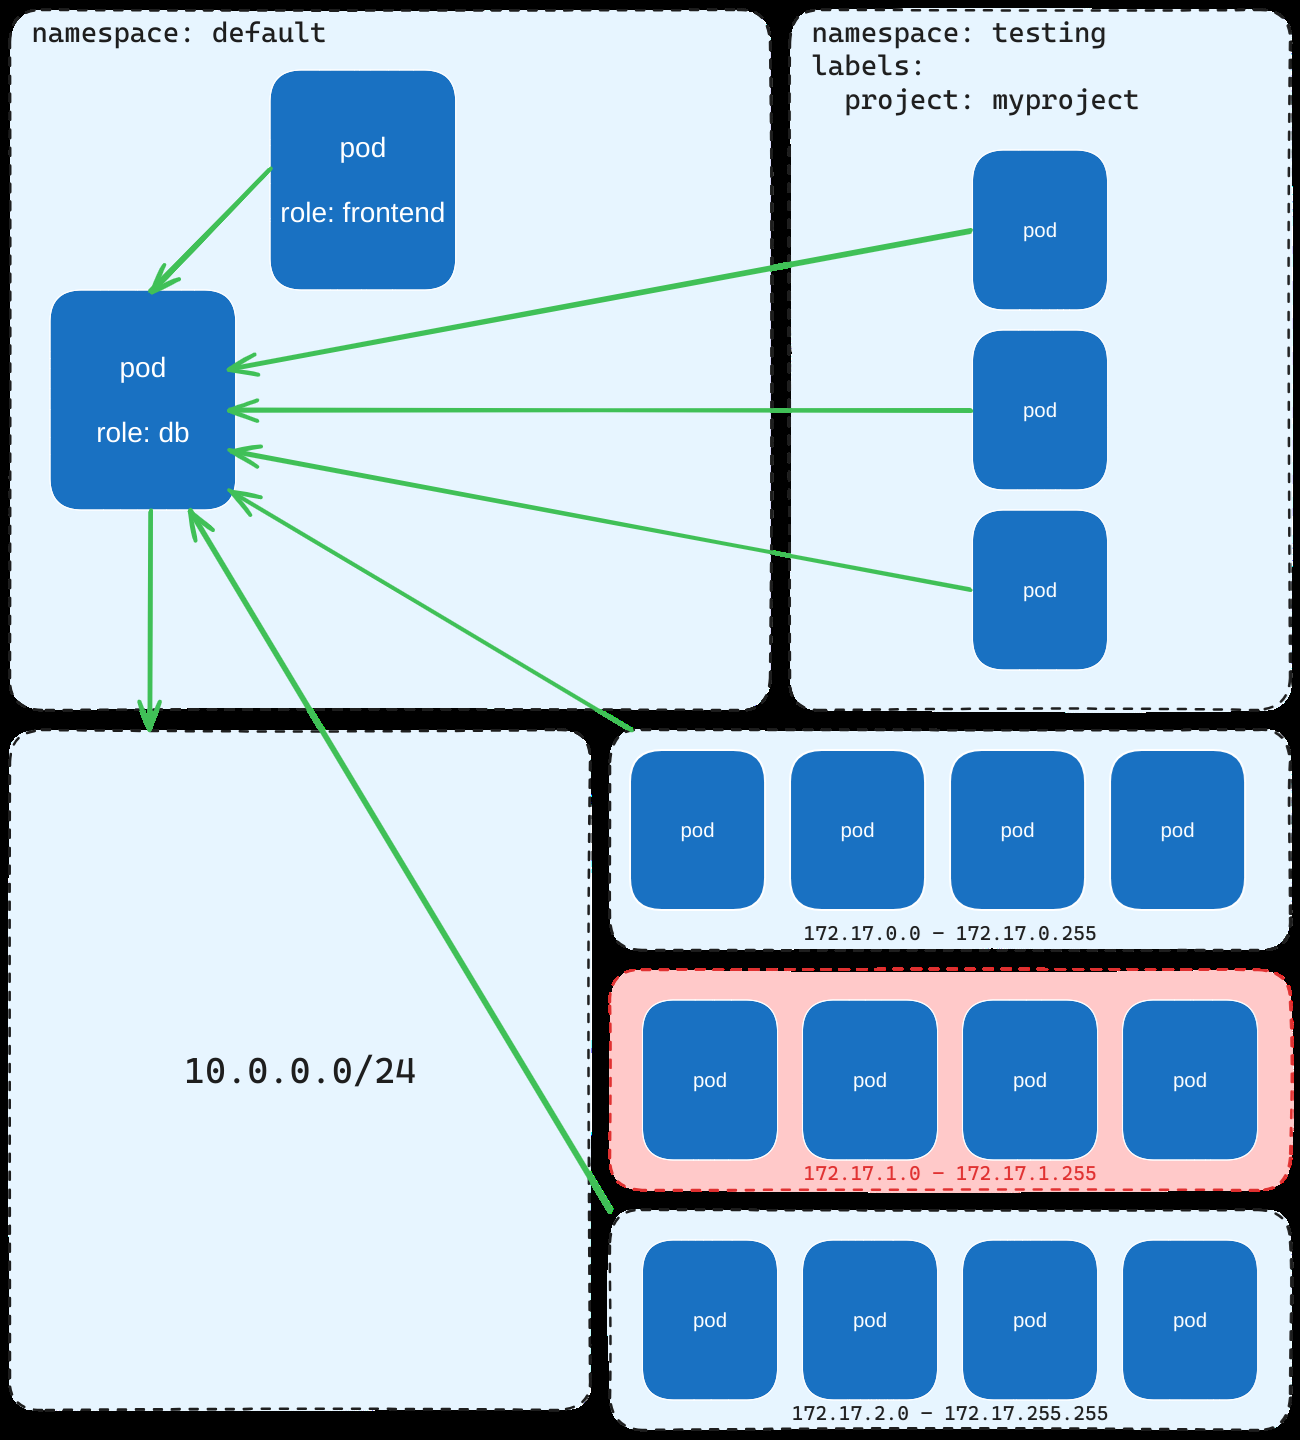

Image Path: data_pdf/image_192.png
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:52+00:00
Certainty: 0.8054370880126953
--------------------------------------------------


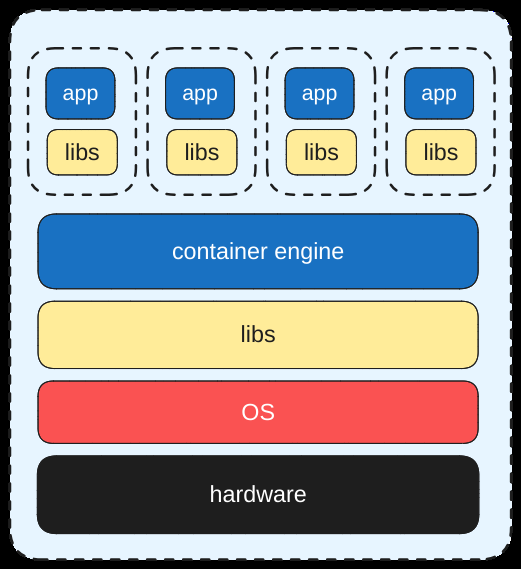

Image Path: data_pdf/image_14.png
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8047797679901123
--------------------------------------------------


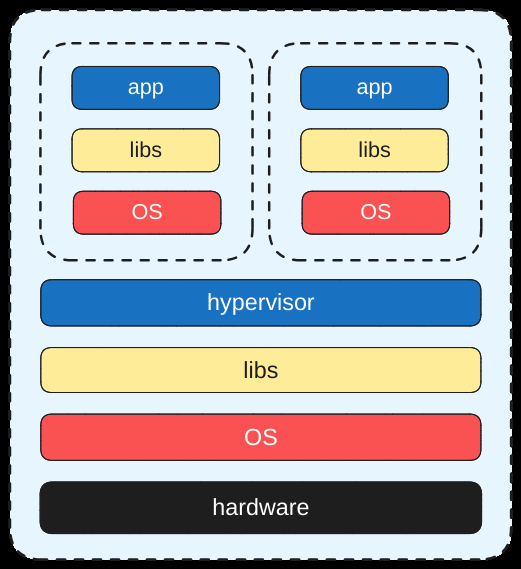

Image Path: data_pdf/image_12.png
Source: rsa-doc.pdf
Timestamp: 2024-07-01 09:01:50+00:00
Certainty: 0.8009343147277832
--------------------------------------------------


In [ ]:
from PIL import Image
from IPython.display import display
import datetime

def display_image_with_metadata(image_path, metadata):
    try:
        # Load and display the image
        img = Image.open(image_path)
        display(img)

        # Print metadata
        print("Image Path:", image_path)
        print("Source:", metadata.get('source', 'N/A'))
        print("Timestamp:", metadata.get('timestamp', 'N/A'))
        print("Certainty:", metadata.get('certainty', 'N/A'))
        print("-" * 50)
    except Exception as e:
        print(f"Could not load image {image_path}. Error: {str(e)}")

def print_and_display_images(response):
    # Check if response is valid and has objects
    if not response or not hasattr(response, 'objects') or not response.objects:
        print("No valid response data.")
        return

    for obj in response.objects:
        properties = obj.properties
        metadata = {
            'source': properties.get('source', 'N/A'),
            'timestamp': properties.get('timestamp', 'N/A'),
            'certainty': getattr(obj.metadata, 'certainty', 'N/A')
        }
        image_path = properties.get('image_path', 'N/A')
        if image_path != 'N/A':
            display_image_with_metadata(image_path, metadata)


print_and_display_images(response)
